<a href="https://www.kaggle.com/jarupula/mh-ode-to-code-pred-weather-6th-place-sol?scriptVersionId=88616025" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Machine Hack - Ode To Code: Predicting Weather Using Alien Fruit Properties🍊

- https://machinehack.com/hackathon/odetocode_predicting_weather_using_alien_fruit_properties/overview

#### Problem Statement:

The year is 2050 and a team of astronauts from all over the world went on a mission to an Exoplanet and discovered a vast amount of life and awesome weather. The scientists began collecting data samples of fruits found in their landing site and were curious by their shape and size. They collected data for more than a solar year of the planet to understand the fruit growing conditions in different weathers. 

To analyze data and grow fruits similar to earth, they began transmitting data back to the Earth, however, due to solar radiation, some data got corrupted and got lost in transmission. Back on Earth, the scientists figured they need to identify the type of climate the exoplanet has based on the properties of the fruit with the existing challenge of missing data. Help the scientists identify the earth-like season in which the fruit must have grown using the data collected.

# Importing libraries📚

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Reading data📋

In [2]:
train = pd.read_csv('../input/machinehack-ode-to-codedata/train.csv', na_values='')
test = pd.read_csv('../input/machinehack-ode-to-codedata/test.csv', na_values='')
sample_sub = pd.read_csv('../input/machinehack-ode-to-codedata/sample_submission.csv')

In [3]:
print(f'\nTrain shape: {train.shape}, \nTest shape: {test.shape}, \nSample shape: {sample_sub.shape}')


Train shape: (42748, 14), 
Test shape: (18321, 14), 
Sample shape: (18321, 1)


In [4]:
train.head()

,edible-poisonous,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,p,5.75,x,n,t,s,w,6.13,14.93,w,f,f,d,a
1,p,2.27,o,g,f,f,f,0.00,0.00,f,f,f,d,s
2,p,5.59,c,y,t,x,p,5.47,11.27,w,f,f,d,a
3,p,0.74,x,p,f,a,n,4.33,0.98,k,f,f,d,a
4,p,9.60,x,n,f,a,w,10.84,28.52,w,f,f,d,u


#### Missing values counts

In [5]:
train.isna().sum()

edible-poisonous           0
cap-diameter               0
cap-shape                  0
cap-color                  0
does-bruise-or-bleed       0
gill-attachment         6940
gill-color                 0
stem-height                0
stem-width                 0
stem-color                 0
has-ring                   0
ring-type               1719
habitat                    0
season                     0
dtype: int64

✔ We have missing values in train data in two columns

In [6]:
test.isna().sum()

edible-poisonous            0
cap-diameter                0
cap-shape                   0
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          2944
gill-color                  0
stem-height                 0
stem-width                  0
stem-color                  0
has-ring                    0
ring-type                 752
habitat                     0
season                  18321
dtype: int64

✔ Same columns are missing in both train and test

✔ Missing ratio(~) is preserved in train and test

In [7]:
train.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99, 0.999])

,cap-diameter,stem-height,stem-width
count,42748.000000,42748.000000,42748.000000
mean,6.712018,6.580449,12.133964
std,5.203768,3.368385,10.058929
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.190000
50%,5.840000,5.950000,10.140000
75%,8.540000,7.740000,16.530000
80%,9.310000,8.300000,17.940000
90%,11.893000,10.430000,24.403000
95%,15.070000,12.550000,30.016500


In [8]:
train.season.value_counts(dropna=False)

a    21103
u    16055
w     3698
s     1892
Name: season, dtype: int64

# Pre-Processing 🛠

In [9]:
def map_bool_cols(df):
    e_p = {'p': 1, 'e': 0}
    b_b = {'t': 1, 'f': 0}
    h_r = {'t': 1, 'f': 0}
    
    df['edible-poisonous'] = df['edible-poisonous'].map(e_p)
    df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].map(b_b)
    df['has-ring'] = df['has-ring'].map(h_r)
    
    return df

In [10]:
train = map_bool_cols(train)
test = map_bool_cols(test)

In [11]:
num_cols = ['edible-poisonous','cap-diameter','does-bruise-or-bleed','stem-height',
            'stem-width','has-ring']
cat_cols = ['cap-shape', 'cap-color', 'gill-color', 'stem-color', 'habitat']

## Imputing missing values

#### gill-attachment

#### Missing values are predicted using a simple NN instead of using simple impute methods

In [12]:
temp_gill = train.drop(['ring-type', 'season'], axis=1).copy()
train_gill = temp_gill[temp_gill['gill-attachment'].fillna(0) != 0] #non-missing value rows
test_gill = temp_gill[temp_gill['gill-attachment'].isna()] # missing value rows
test_gill_indexes = test_gill.index

trainsforming categorical columns and not changing numerical columns

In [13]:
featurization_gill = ColumnTransformer(transformers=[
    ('one_hot_gill_x', OneHotEncoder(), cat_cols), # OHE categorical columns
    ('num_pass', 'passthrough', num_cols) # Don't transform numerical columns
])

In [14]:
X_gill = featurization_gill.fit_transform(train_gill.drop('gill-attachment', axis=1))
one_hot_gill_y = OneHotEncoder()
y_gill = one_hot_gill_y.fit_transform(np.array(train_gill['gill-attachment']).reshape(-1, 1))

X_gill_train, X_gill_val, y_gill_train, y_gill_val = train_test_split(X_gill, y_gill, 
                                                                      random_state=42)

model_gill = keras.models.Sequential([
    keras.layers.Input(shape=X_gill.shape[1]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])
model_gill.compile('adam', loss='categorical_crossentropy')


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [15]:
model_gill.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3776      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 6,087
Trainable params: 6,087
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model_gill.fit(X_gill_train.toarray(), y_gill_train.toarray(), 
                         validation_data=(X_gill_val.toarray(), y_gill_val.toarray()), epochs=10)

2022-02-24 05:32:11.920956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
840/840 [==============================] - 3s 2ms/step - loss: 0.8682 - val_loss: 0.4982
Epoch 2/10
840/840 [==============================] - 2s 2ms/step - loss: 0.3769 - val_loss: 0.2879
Epoch 3/10
840/840 [==============================] - 2s 2ms/step - loss: 0.2433 - val_loss: 0.2026
Epoch 4/10
840/840 [==============================] - 2s 2ms/step - loss: 0.1730 - val_loss: 0.1526
Epoch 5/10
840/840 [==============================] - 2s 2ms/step - loss: 0.1330 - val_loss: 0.1367
Epoch 6/10
840/840 [==============================] - 2s 2ms/step - loss: 0.1090 - val_loss: 0.1022
Epoch 7/10
840/840 [==============================] - 2s 2ms/step - loss: 0.0976 - val_loss: 0.0920
Epoch 8/10
840/840 [==============================] - 2s 2ms/step - loss: 0.0849 - val_loss: 0.0862
Epoch 9/10
840/840 [==============================] - 2s 2ms/step - loss: 0.0770 - val_loss: 0.0729
Epoch 10/10
840/840 [==============================] - 2s 2ms/step - loss: 0.0772 - val_loss: 0.0827

In [17]:
preds = model_gill.predict(featurization_gill.transform(test_gill))

In [18]:
for i, idx in enumerate(test_gill_indexes):
    train.loc[idx, 'gill-attachment'] = one_hot_gill_y.inverse_transform(np.array(preds[i]).reshape(1, -1))[0][0]

In [19]:
test_gill_df = test[test['gill-attachment'].isna()].drop(['ring-type', 'season'], axis=1).copy()
test_gill_indexes_df = test_gill_df.index

In [20]:
test_preds_gill = model_gill.predict(featurization_gill.transform(test_gill_df))

In [21]:
# Transforming test set
for i, idx in enumerate(test_gill_indexes_df):
    test.loc[idx, 'gill-attachment'] = one_hot_gill_y.inverse_transform(
        np.array(test_preds_gill[i]).reshape(1, -1))[0][0] 

### ring-type

In [22]:
temp_ring = train.drop(['gill-attachment', 'season'], axis=1).copy()
train_ring = temp_ring[temp_ring['ring-type'].fillna(0) != 0] # Non-missing value rows
test_ring = temp_ring[temp_ring['ring-type'].isna()] # Missing value rows
test_ring_indexes = test_ring.index

In [23]:
featurization_ring = ColumnTransformer(transformers=[
    ('one_hot_ring_x', OneHotEncoder(), cat_cols),
    ('num_pass', 'passthrough', num_cols)
])

In [24]:
X_ring = featurization_ring.fit_transform(train_ring.drop('ring-type', axis=1))
one_hot_ring_y = OneHotEncoder()
y_ring = one_hot_ring_y.fit_transform(np.array(train_ring['ring-type']).reshape(-1, 1))

X_ring_train, X_ring_val, y_ring_train, y_ring_val = train_test_split(X_ring, y_ring, 
                                                                      random_state=42)

model_ring = keras.models.Sequential([
    keras.layers.Input(shape=X_ring.shape[1]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='softmax')
])
model_ring.compile('adam', loss='categorical_crossentropy')

In [25]:
model_ring.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                3776      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
Total params: 6,120
Trainable params: 6,120
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_ring = model_ring.fit(X_ring_train.toarray(), y_ring_train.toarray(), 
                         validation_data=(X_ring_val.toarray(), y_ring_val.toarray()), epochs=10)

Epoch 1/10
962/962 [==============================] - 3s 2ms/step - loss: 0.2927 - val_loss: 0.0895
Epoch 2/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0629 - val_loss: 0.0525
Epoch 3/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0449 - val_loss: 0.0435
Epoch 4/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0400 - val_loss: 0.0407
Epoch 5/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0373 - val_loss: 0.0439
Epoch 6/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0369 - val_loss: 0.0370
Epoch 7/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0344 - val_loss: 0.0384
Epoch 8/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0336 - val_loss: 0.0470
Epoch 9/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0334 - val_loss: 0.0331
Epoch 10/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0327 - val_loss: 0.0342

In [27]:
preds_ring = model_ring.predict(featurization_ring.transform(test_ring))

In [28]:
for i, idx in enumerate(test_ring_indexes):
    train.loc[idx, 'ring-type'] = one_hot_ring_y.inverse_transform(np.array(preds_ring[i]).reshape(1, -1))[0][0]

In [29]:
test_ring_df = test[test['ring-type'].isna()].drop(['gill-attachment', 'season'], axis=1).copy()
test_ring_indexes_df = test_ring_df.index

In [30]:
test_preds_ring = model_ring.predict(featurization_ring.transform(test_ring_df))

In [31]:
for i, idx in enumerate(test_ring_indexes_df):
    test.loc[idx, 'ring-type'] = one_hot_ring_y.inverse_transform(
        np.array(test_preds_ring[i]).reshape(1, -1))[0][0]

In [32]:
train.isna().sum()

edible-poisonous        0
cap-diameter            0
cap-shape               0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

In [33]:
test.isna().sum()

edible-poisonous            0
cap-diameter                0
cap-shape                   0
cap-color                   0
does-bruise-or-bleed        0
gill-attachment             0
gill-color                  0
stem-height                 0
stem-width                  0
stem-color                  0
has-ring                    0
ring-type                   0
habitat                     0
season                  18321
dtype: int64

# Training🏋️‍♂️

In [34]:
num_cols_final = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols_final = train.select_dtypes(include=['object']).columns[:-1]

In [35]:
featurization = ColumnTransformer(transformers=[
    ('final_onehot', OneHotEncoder(), cat_cols_final),
    ('final_num', 'passthrough', num_cols_final)
])

In [36]:
one_hot_final = OneHotEncoder()

In [37]:
X = featurization.fit_transform(train.drop('season', axis=1))
y = one_hot_final.fit_transform(np.array(train['season']).reshape(-1, 1))

X_test = featurization.transform(test.drop('season', axis=1))

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X.toarray(), y.toarray(), 
                                                  random_state=42, test_size=0.2)

In [39]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(X.shape[1], )),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

In [40]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               9472      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 68        
Total params: 18,836
Trainable params: 18,836
Non-trainable params: 0
__________________________________________________

In [42]:
history_ = model.fit(X_train, y_train, 
                     validation_data=(X_val, y_val), 
                     epochs=25, batch_size=64)

Epoch 1/25
535/535 [==============================] - 2s 3ms/step - loss: 1.0760 - accuracy: 0.4780 - val_loss: 0.9548 - val_accuracy: 0.4986
Epoch 2/25
535/535 [==============================] - 2s 3ms/step - loss: 0.9451 - accuracy: 0.5008 - val_loss: 0.8837 - val_accuracy: 0.5011
Epoch 3/25
535/535 [==============================] - 2s 3ms/step - loss: 0.8796 - accuracy: 0.5115 - val_loss: 0.8399 - val_accuracy: 0.5158
Epoch 4/25
535/535 [==============================] - 2s 3ms/step - loss: 0.8372 - accuracy: 0.5152 - val_loss: 0.7961 - val_accuracy: 0.5108
Epoch 5/25
535/535 [==============================] - 2s 3ms/step - loss: 0.8061 - accuracy: 0.5224 - val_loss: 0.7712 - val_accuracy: 0.5132
Epoch 6/25
535/535 [==============================] - 2s 3ms/step - loss: 0.7846 - accuracy: 0.5199 - val_loss: 0.7596 - val_accuracy: 0.5088
Epoch 7/25
535/535 [==============================] - 2s 3ms/step - loss: 0.7699 - accuracy: 0.5212 - val_loss: 0.7565 - val_accuracy: 0.5135
Epoch 

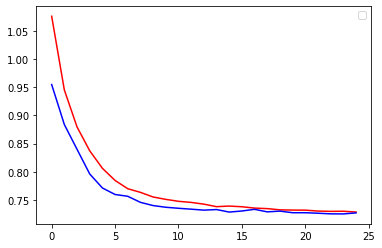

In [43]:
plt.plot(history_.history['loss'], '-r')
plt.plot(history_.history['val_loss'], '-b')
plt.legend()
plt.show()

# Inference🛰

In [44]:
test_preds_final = model.predict(X_test.toarray())

In [45]:
for i in range(sample_sub.shape[0]):
    sample_sub.loc[i, 'season'] = one_hot_final.inverse_transform(
        np.array(test_preds_final[i]).reshape(1, -1))[0][0]

In [46]:
sample_sub

,season
0,u
1,u
2,u
3,u
4,u
...,...
18316,u
18317,u
18318,u
18319,u


In [47]:
sample_sub.to_csv('submission.csv', index=None)